# Predict whether a patient got COVID-19 based on volatility organic components
- https://www.medrxiv.org/content/10.1101/2020.06.21.20136523v1.full.pdf
- this notebook will utilize potential breath-borne volatile organic compound (VOC) biomarkers for COVID-19 predictions


# Import common data package

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe

# Import dataset

In [3]:
df = pd.read_csv("covid_voc.csv")
df_code = pd.read_csv("chemical_code.csv")
df.head()

,Label,Area1,Area2,Area3,Area4,Area5,Area6,Area7,Area8,Area9,...,Area31,Area32,Area33,Area34,Area35,Area36,Area37,Area38,Area39,Area40
0,COVID,303.260,251.998,-29.187,-3.123,-7.288,748.266,135.607,294.740,1040.121,...,-0.422,0.857,0.298,34.735,2.828,-2.108,-49.078,-2.719,9.717,12.598
1,COVID,152.747,18.797,13.180,-21.675,6.972,501.789,59.226,285.557,-222.315,...,1.406,3.714,1.378,30.263,0.471,3.517,-5.085,0.244,0.774,-4.739
2,COVID,32.504,12.683,15.900,20.038,6.354,1271.839,466.516,525.410,630.564,...,0.311,1.524,-2.011,89.112,0.259,-0.287,-19.341,0.863,5.543,-0.183
3,COVID,35.671,69.575,3.098,24.018,25.976,328.122,22.780,-1123.835,-1838.917,...,1.032,-0.528,1.132,12.401,0.511,3.471,-42.521,1.719,33.767,-429.364
4,COVID,526.066,166.963,-17.990,5.247,-1.054,808.812,136.308,218.977,-170.202,...,-0.030,4.632,1.384,37.861,0.595,-0.667,4.847,0.168,-85.772,-14.023


# Dataset splitting

In [4]:
X = df.drop(columns="Label")
y = df.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30, 40), (30, 40), (30,), (30,))

In [5]:
df.columns

Index(['Label', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'Area6', 'Area7',
       'Area8', 'Area9', 'Area10', 'Area11', 'Area12', 'Area13', 'Area14',
       'Area15', 'Area16', 'Area17', 'Area18', 'Area19', 'Area20', 'Area21',
       'Area22', 'Area23', 'Area24', 'Area25', 'Area26', 'Area27', 'Area28',
       'Area29', 'Area30', 'Area31', 'Area32', 'Area33', 'Area34', 'Area35',
       'Area36', 'Area37', 'Area38', 'Area39', 'Area40'],
      dtype='object')

In [6]:
df.Label.value_counts()

URTI               22
Healthy control    12
COVID              10
HCW                 9
Lung Cancer         7
Name: Label, dtype: int64

In [7]:
50/60

0.8333333333333334

# Data preprocessing & training

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ['Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'Area6', 'Area7',
       'Area8', 'Area9', 'Area10', 'Area11', 'Area12', 'Area13', 'Area14',
       'Area15', 'Area16', 'Area17', 'Area18', 'Area19', 'Area20', 'Area21',
       'Area22', 'Area23', 'Area24', 'Area25', 'Area26', 'Area27', 'Area28',
       'Area29', 'Area30', 'Area31', 'Area32', 'Area33', 'Area34', 'Area35',
       'Area36', 'Area37', 'Area38', 'Area39', 'Area40'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    2.6s finished


{'algo__C': 10.0, 'algo__gamma': 0.1}
1.0 0.7666666666666666 0.9


# Plot confusion matrix

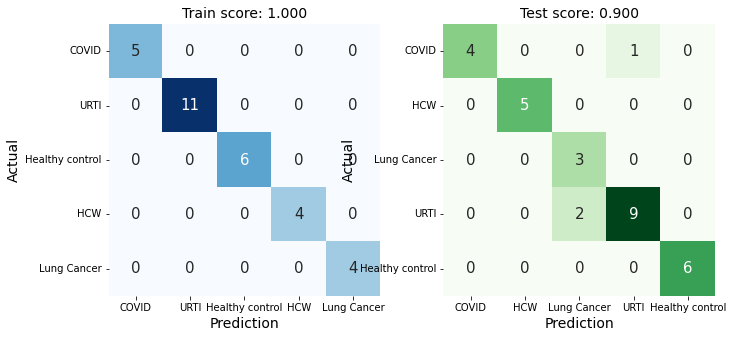

In [10]:
from jcopml.plot import plot_confusion_matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Exploratory data analysis
- visualizing chemical in box plot for each case

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df_code.head()

,code,label
0,Area1,Acetic acid
1,Area2,Acetoin
2,Area3,Unknown-6
3,Area4,Butanol-1*
4,Area5,Butanol-2*


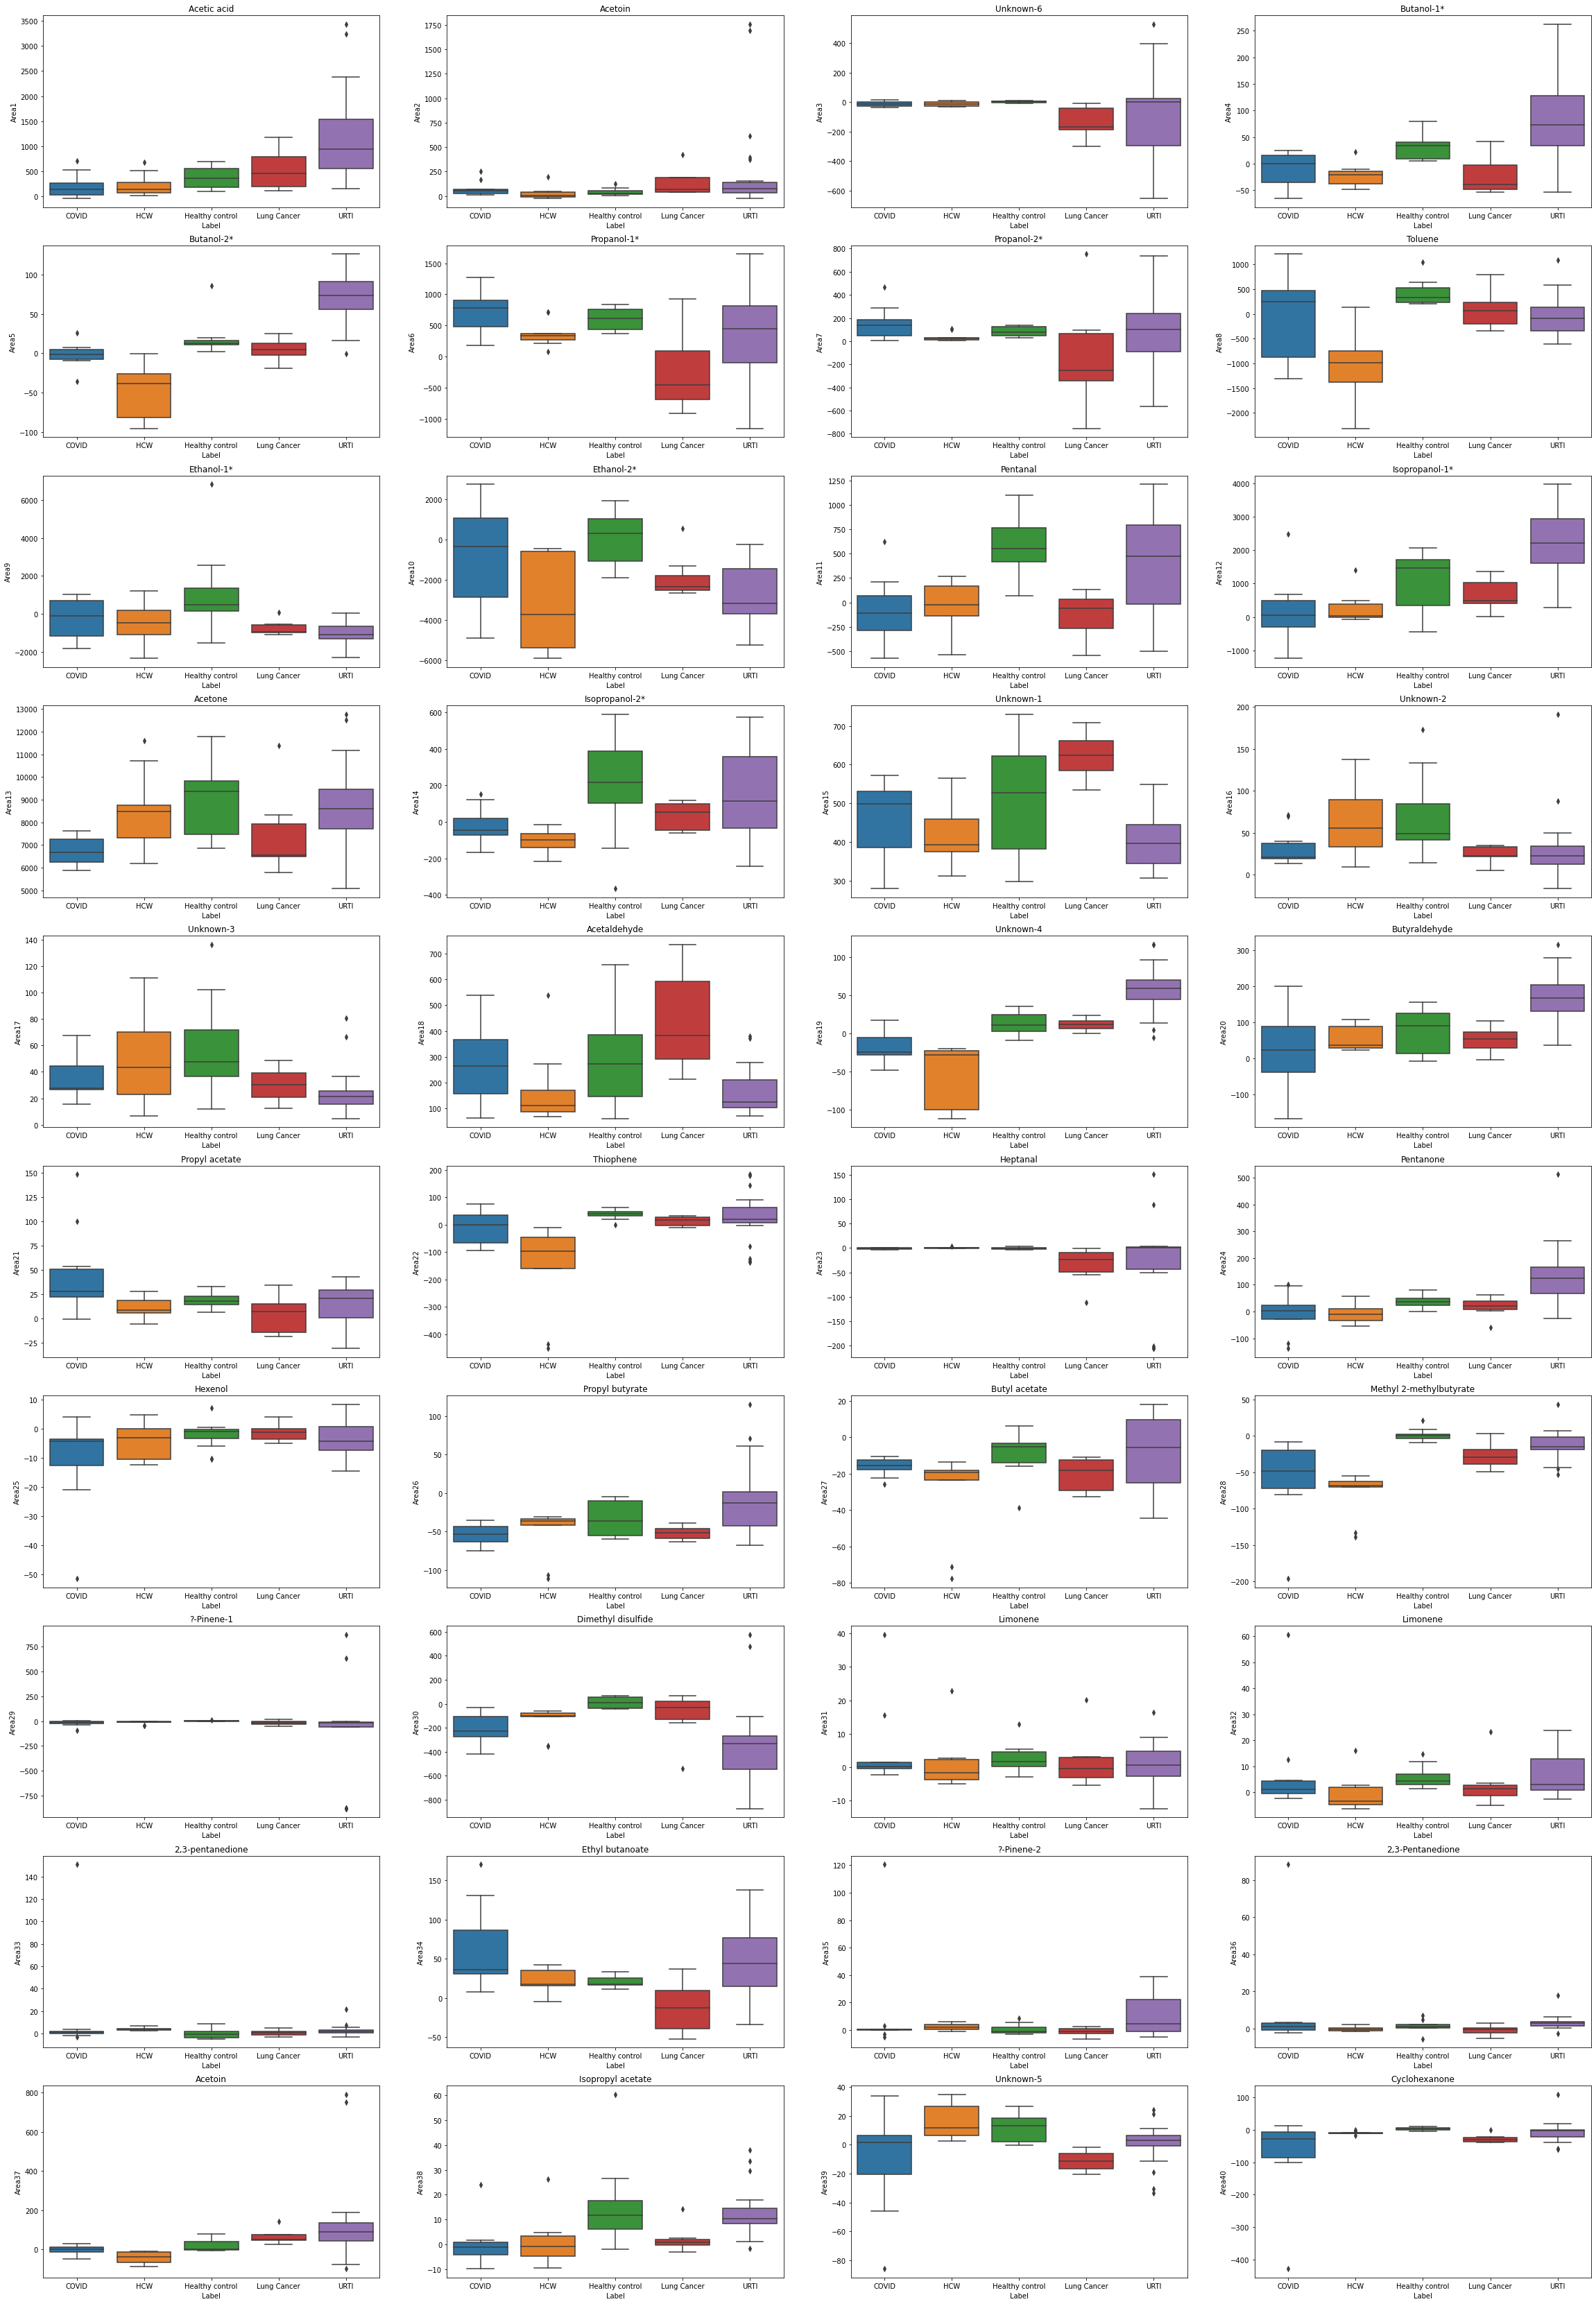

In [13]:
import warnings
warnings.filterwarnings('ignore')

#For boxplot data
fig, ax = plt.subplots(10,4, figsize =(40,60)) #row, col #width, height
row = [0,1,2,3,4,5,6,7,8,9]
col = [0,1,2,3]
chemical_code = iter(df.columns)
kode = next(chemical_code) #skip first column (label)

#For title
chem_name = iter(df_code.label)

for i in row:
    for j in col:
        kode = next(chemical_code)
        ax[i,j].set_title(next(chem_name))
        sns.boxplot(df.Label, df[kode], ax= ax[i,j])

In [14]:
fig.savefig("output.png")

<AxesSubplot:>

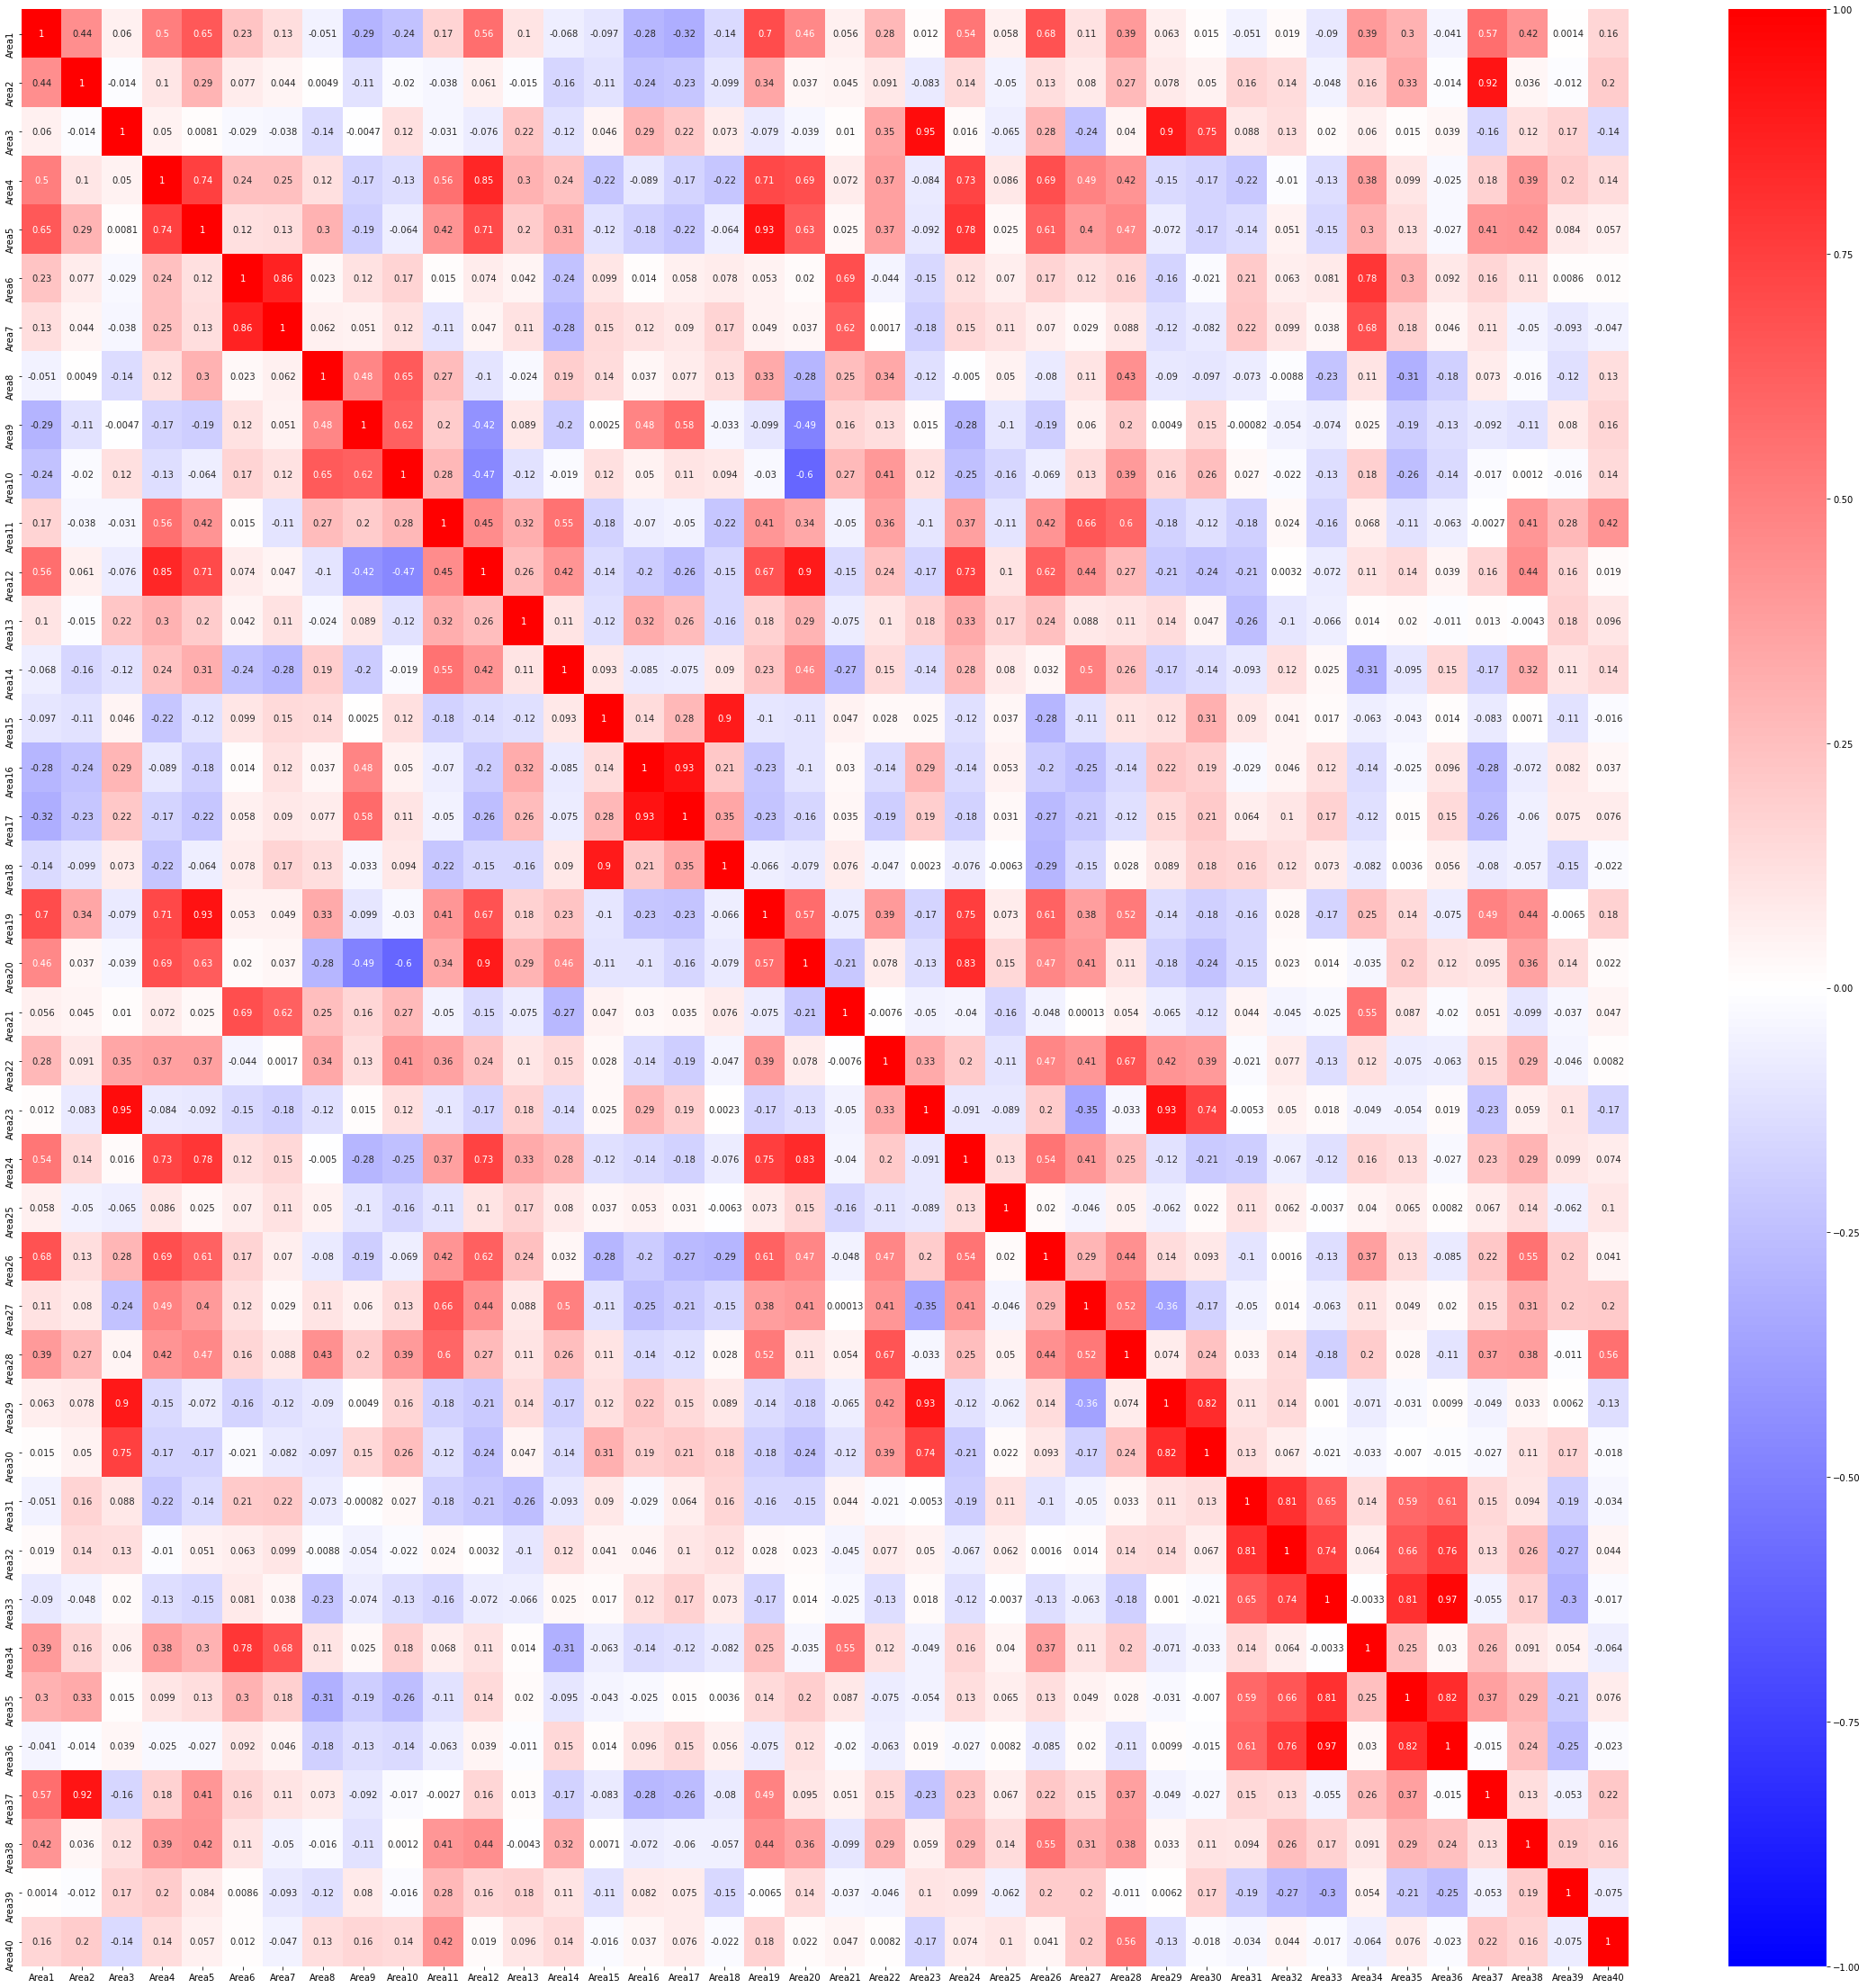

In [15]:
fig = plt.figure(figsize= (40,40))
sns.heatmap(df.corr(), vmax =1, vmin=-1,  cmap='bwr', annot= True)

# Principal component analysis

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
pca = PCA(n_components = 2, whiten=True) # whiten --> scaling , PCA dapat dibantu kalau di-scaling
X_pca = pca.fit_transform(X)

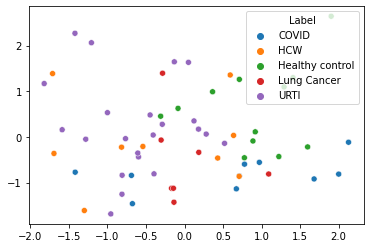

In [18]:
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue= y);

In [19]:
df_code.label

0                 Acetic acid
1                     Acetoin
2                   Unknown-6
3                  Butanol-1*
4                  Butanol-2*
5                 Propanol-1*
6                 Propanol-2*
7                     Toluene
8                  Ethanol-1*
9                  Ethanol-2*
10                   Pentanal
11             Isopropanol-1*
12                    Acetone
13             Isopropanol-2*
14                  Unknown-1
15                  Unknown-2
16                  Unknown-3
17               Acetaldehyde
18                  Unknown-4
19              Butyraldehyde
20             Propyl acetate
21                  Thiophene
22                   Heptanal
23                  Pentanone
24                    Hexenol
25            Propyl butyrate
26              Butyl acetate
27    Methyl 2-methylbutyrate
28                 ?-Pinene-1
29         Dimethyl disulfide
30                   Limonene
31                   Limonene
32           2,3-pentanedione
33        